In [2]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
parent_dir = file_dir.parent
sys.path.append(str(parent_dir))

%load_ext autoreload
%autoreload

import pandas as pd
import numpy as np

from collections import namedtuple

from pa_lib.file import (
    store_bin,
    project_dir,
    data_files,
    load_csv,
    load_bin,
    write_xlsx,
    load_txt
)

from pa_lib.data import (
    as_dtype,
    dtFactor,
    desc_col,
    lookup,
    clean_up_categoricals
)

from pa_lib.util import (
    collect,
    value,
    flatten,
    normalize_rows,
    list_items
)

from pa_lib.log import time_log
from pa_lib.types import Record

# display long columns completely, show more rows
pd.set_option("display.max_colwidth", 300)
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

# Load data files

In [3]:
with project_dir("MediaFocus"):
    # List files in folder:
    display(data_files("*.feather"))
    
    # Branchen per KW über sie letzten 10 Jahre:
    br_kw     = load_bin("branchen_kw_10y.feather").astype({'Jahr': 'int64'})
    
    # Wie oben, aber unterhalb Branchen noch nach Produktgruppen aufgeteilt:
    br_pg_kw  = load_bin("branchen_pg_kw_10y.feather")
    
    
    br_wbt_kw = load_bin("branchen_wbt_kw.feather")

,size,mtime
name,,
branchen_kw_10y.feather,100.9 KB,31.10.19 15:28:44
branchen_pg_kw_10y.feather,553.2 KB,31.10.19 15:28:44
branchen_wbt_kw.feather,15.2 MB,31.10.19 15:28:44


09:15:37 [INFO] Started loading binary file ...
09:15:37 [INFO] Reading from file C:\Users\stc\data\MediaFocus\branchen_kw_10y.feather
09:15:37 [INFO] ... finished loading binary file in 0.07s (0.02s CPU)
09:15:37 [INFO] Started loading binary file ...
09:15:37 [INFO] Reading from file C:\Users\stc\data\MediaFocus\branchen_pg_kw_10y.feather
09:15:37 [INFO] ... finished loading binary file in 0.0s (0.0s CPU)
09:15:37 [INFO] Started loading binary file ...
09:15:37 [INFO] Reading from file C:\Users\stc\data\MediaFocus\branchen_wbt_kw.feather
09:15:37 [INFO] ... finished loading binary file in 0.01s (0.02s CPU)


In [4]:
print(80*"#"+"\n")
print("br_kw")
display(br_kw.shape)
display(
    br_kw.sample(5)
)


print(80*"#"+"\n")
print("br_pg_kw")
display(br_pg_kw.shape)
display(
    br_pg_kw.sample(5)
)


print(80*"#"+"\n")
print("br_wbt_kw")
display(br_wbt_kw.shape)
display(
    br_wbt_kw.sample(5)
)
print(80*"#")

################################################################################

br_kw


(231, 55)

,Jahr,Branche,KW_01,KW_02,KW_03,KW_04,KW_05,KW_06,KW_07,KW_08,KW_09,KW_10,KW_11,KW_12,KW_13,KW_14,KW_15,KW_16,KW_17,KW_18,KW_19,KW_20,KW_21,KW_22,KW_23,KW_24,KW_25,KW_26,KW_27,KW_28,KW_29,KW_30,KW_31,KW_32,KW_33,KW_34,KW_35,KW_36,KW_37,KW_38,KW_39,KW_40,KW_41,KW_42,KW_43,KW_44,KW_45,KW_46,KW_47,KW_48,KW_49,KW_50,KW_51,KW_52,KW_53
195,2018,FINANZEN,2690259,2768342,3422356,3883811,6545414,4763201,4509966,4807931,10218875,7380438,7325187,6853228,8049697,4886859,6064123,6950231,7059974,10808461,5822729,6273012,5982355,11459600,6797821,5981221,5484261,5986171,4191418,4282602,1975923,2292604,4482439,2313728,4986259,7581165,11263770,8785559,12723220,12223110,10134532,13421373,5372068,7597776,9473900,13952824,9508010,8355834,6353684,7946081,3835896,2914556,3154024,3064796,0
219,2019,INITIATIVEN + KAMPAGNEN,5050430,4713772,5866538,5196910,5583455,4912737,4463050,5490002,7667218,7244676,7622490,6904686,6192415,6968274,7165912,6741265,5473593,8411728,8170182,6618501,4362410,5185904,5564454,4998609,6039860,5678852,5997338,5521722,3624744,4375521,5598960,4372655,5891318,5818981,7993861,8367138,7615561,8515365,10647103,1332685,0,0,0,0,0,0,0,0,0,0,0,0,0
61,2011,VERANSTALTUNGEN,3219486,3760820,4336256,4327025,4605476,4030862,4232284,5231497,6318085,5154604,5027481,5671932,5732669,5285710,4907687,4980321,5905654,5523089,4892978,5823138,5869500,5380218,5659445,5434810,5430508,5393905,4145082,3647806,3193995,3545166,3625298,4176248,5431173,6305324,7430127,6092322,5997150,6455922,6309734,5684842,4881195,5462698,7040488,7201827,5800528,5991786,5857339,7328514,5546244,5682235,3754563,3206570,0
9,2009,INITIATIVEN + KAMPAGNEN,2320253,6638247,6410847,8209792,7696856,7216430,4189615,3788099,4210198,3614453,3394288,4208445,3848273,5273664,4413010,4641372,4915764,5713075,5289768,4336652,3991590,4536933,4668800,3871501,4636502,4699637,4283470,3381632,2709444,2547013,3818951,3079709,3767196,4730125,5591350,8111465,7694502,7513681,8967904,6523994,4476197,4067106,5611241,6907233,7286386,6040146,8142610,7204222,6387559,7615045,7217566,5286436,2580350
226,2019,REINIGEN,794926,1043871,1454243,1275833,1170824,1280859,1710287,1505771,1896312,1847714,1353131,1653245,1854625,2073148,1746535,2014825,2200900,1393623,1511450,912638,954418,838650,772581,732195,876306,845342,989950,966227,1458001,1247915,1290116,1110391,1554118,1427259,1531429,2219879,2839547,1903692,1881476,376192,0,0,0,0,0,0,0,0,0,0,0,0,0


################################################################################

br_pg_kw


(1309, 56)

,Jahr,Branche,Produktgruppe,KW_01,KW_02,KW_03,KW_04,KW_05,KW_06,KW_07,KW_08,KW_09,KW_10,KW_11,KW_12,KW_13,KW_14,KW_15,KW_16,KW_17,KW_18,KW_19,KW_20,KW_21,KW_22,KW_23,KW_24,KW_25,KW_26,KW_27,KW_28,KW_29,KW_30,KW_31,KW_32,KW_33,KW_34,KW_35,KW_36,KW_37,KW_38,KW_39,KW_40,KW_41,KW_42,KW_43,KW_44,KW_45,KW_46,KW_47,KW_48,KW_49,KW_50,KW_51,KW_52,KW_53
1025,2017,MODE + SPORT,SCHUHE,100183,40245,58437,47481,33741,4999,8969,221335,386555,102455,788733,884215,1339736,1188116,1180487,306607,344118,350821,595997,646256,250773,166511,13811,64265,57879,52249,48931,38455,29138,66137,56628,180132,223288,82744,192092,290087,615751,499013,500964,486715,239640,259573,401738,139996,192060,209862,148183,73966,175012,69345,58825,66114,0
49,2009,INITIATIVEN + KAMPAGNEN,GEMEINNUETZIGE KAMPAGNEN,800635,2517753,2347825,2338990,1909750,1939565,1872480,1714071,1681976,1685649,1465544,1651670,1458960,2016060,1691846,2642021,2190577,2143593,2634101,2004684,2093301,2099781,2533136,1835362,2032489,1504773,1283298,1721577,1158283,1218939,1695677,1579236,2439489,2303922,1627183,2910654,3021673,2758767,3614374,2806313,2057127,1905178,1896627,2630708,3252668,2881175,2447882,2865073,2856352,2640308,2290752,1937300,982553
614,2014,DIGITAL + HAUSHALT,FOTO + VIDEO,269016,84526,52873,219963,640039,5510,11482,41347,203533,24694,54160,73934,54159,382071,196784,190965,134004,292054,204995,89108,63203,287863,84233,118032,138686,219812,165638,40984,52930,263930,525980,271986,86801,233856,164510,570136,70323,223115,57140,434658,139094,514004,361109,1024291,504377,668516,721755,998362,1518165,1106038,401292,378475,0
1209,2019,DIGITAL + HAUSHALT,FOTO + VIDEO,287278,134478,157947,98396,180868,13049,11524,31139,113550,39585,33535,23615,68045,81363,72473,329457,237027,364666,315239,297857,293161,279807,203283,226367,37071,46276,54178,140074,5510,76611,37250,12344,183304,102583,268033,112183,234294,5704,294566,28570,0,0,0,0,0,0,0,0,0,0,0,0,0
199,2010,NAHRUNGSMITTEL,NAEHRMITTEL,512950,684105,757251,757899,1557529,1382356,883826,698059,1049133,833747,830900,1431921,980808,1209151,1074830,501730,1118040,869317,852578,735953,1082124,1330046,609385,476219,465467,631700,543106,701035,376655,619933,537556,373007,624262,909200,1338724,1400919,1110586,911573,1213723,1333869,1197923,1675110,1065485,1445135,1265685,1332176,1103609,726156,387739,588835,375356,297231,25949


################################################################################

br_wbt_kw


(35471, 55)

,Branche,Werbungtreibender,KW_01,KW_02,KW_03,KW_04,KW_05,KW_06,KW_07,KW_08,KW_09,KW_10,KW_11,KW_12,KW_13,KW_14,KW_15,KW_16,KW_17,KW_18,KW_19,KW_20,KW_21,KW_22,KW_23,KW_24,KW_25,KW_26,KW_27,KW_28,KW_29,KW_30,KW_31,KW_32,KW_33,KW_34,KW_35,KW_36,KW_37,KW_38,KW_39,KW_40,KW_41,KW_42,KW_43,KW_44,KW_45,KW_46,KW_47,KW_48,KW_49,KW_50,KW_51,KW_52,KW_53
20885,FINANZEN,SIY PAYMENT MERCHANT AG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14468,DIENSTLEISTUNG,SWIMAC SWISS MARKETING ACADEMY GMBH,6589,31335,26523,41448,27259,58136,15066,13868,13928,33422,41432,50162,47849,15737,9442,792,5701,2219,15892,2219,21266,22854,37403,27125,792,10105,21103,31637,3645,61653,30106,50790,81386,19802,56632,24612,40666,17428,19603,18751,9392,16013,38712,15361,4212,4954,4487,1634,29926,21254,20116,273,261
16228,DIGITAL + HAUSHALT,MARTHA SOFTWARE GMBH,0,0,0,814,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11788,DIENSTLEISTUNG,INTERSIM AG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25768,INITIATIVEN + KAMPAGNEN,LUNGENLIGA WALLIS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1266,1266,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


################################################################################


# Find patterns

In [21]:
from pa_lib.data  import calc_col_partitioned

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [5]:
len(set(br_kw.loc[:,"Branche"]))

21

In [20]:
kw_columns = list(br_kw.columns)[2:]
br_kw.loc[:,"Brutto"] = br_kw.loc[:,kw_columns].sum(axis="columns")

In [38]:
#kw_columns

In [18]:
br_kw.loc[:, ["Branche", "Jahr", "Brutto"]].sort_values(["Branche", "Jahr"], ascending=[True, True]).head(12)

,Branche,Jahr,Brutto
0,"BAUEN, INDUSTRIE, EINRICHTUNG",2009,225372271
21,"BAUEN, INDUSTRIE, EINRICHTUNG",2010,260734554
42,"BAUEN, INDUSTRIE, EINRICHTUNG",2011,269037451
63,"BAUEN, INDUSTRIE, EINRICHTUNG",2012,264844857
84,"BAUEN, INDUSTRIE, EINRICHTUNG",2013,284518733
105,"BAUEN, INDUSTRIE, EINRICHTUNG",2014,286136196
126,"BAUEN, INDUSTRIE, EINRICHTUNG",2015,278792600
147,"BAUEN, INDUSTRIE, EINRICHTUNG",2016,261621736
168,"BAUEN, INDUSTRIE, EINRICHTUNG",2017,237990117
189,"BAUEN, INDUSTRIE, EINRICHTUNG",2018,234209813


In [9]:
branchen_liste = list(set(br_kw.loc[:,"Branche"]))
branchen_liste[0:7]

['NAHRUNGSMITTEL',
 'INITIATIVEN + KAMPAGNEN',
 'PHARMA + GESUNDHEIT',
 'DIENSTLEISTUNG',
 'VERANSTALTUNGEN',
 'KOSMETIK + KOERPERPFLEGE',
 'MEDIEN']

In [69]:
def lineplot_branches(select_branches):
    branch_select = container_df.loc[:,"Branche"].isin(select_branches)
    plt.figure(
        figsize=(15, 8)
    )

    sns.lineplot(
        data=container_df.loc[branch_select,:].pipe(clean_up_categoricals),
        x="Jahr",
        y="Brutto",
        hue="Branche",
        dashes=True,
        markers=True,
        ci=0.5,
    )

    # Put the legend out of the figure
    plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc=2,
        borderaxespad=0.
    )
    plt.show()



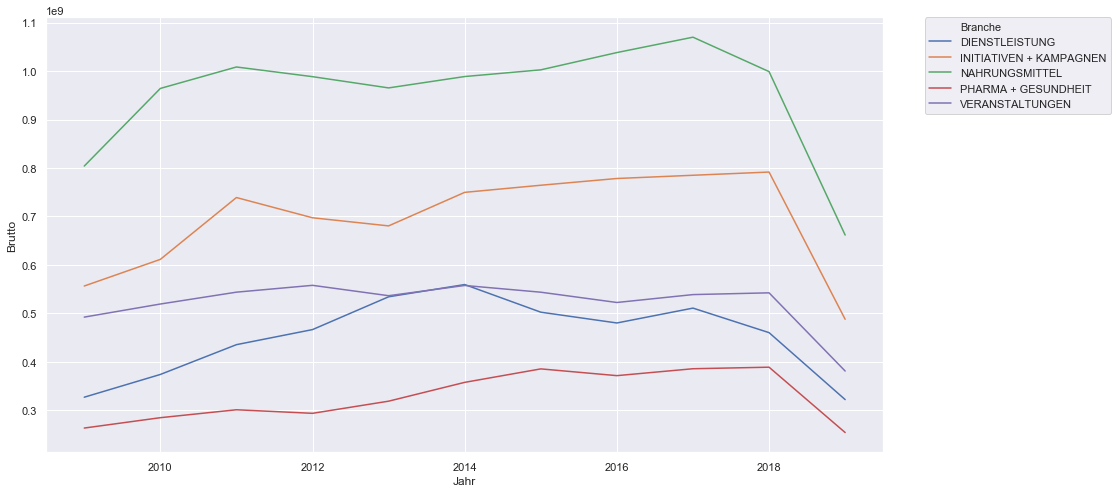

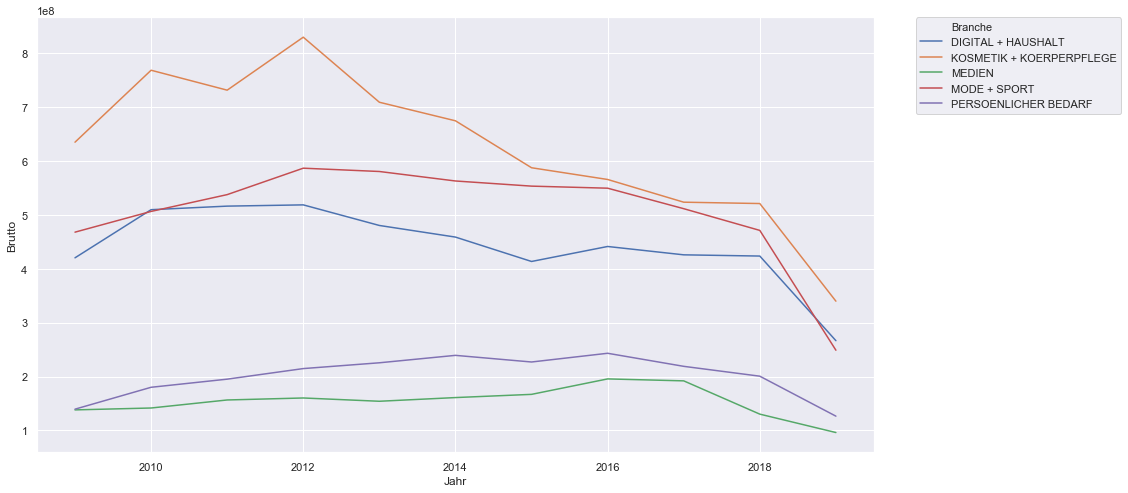

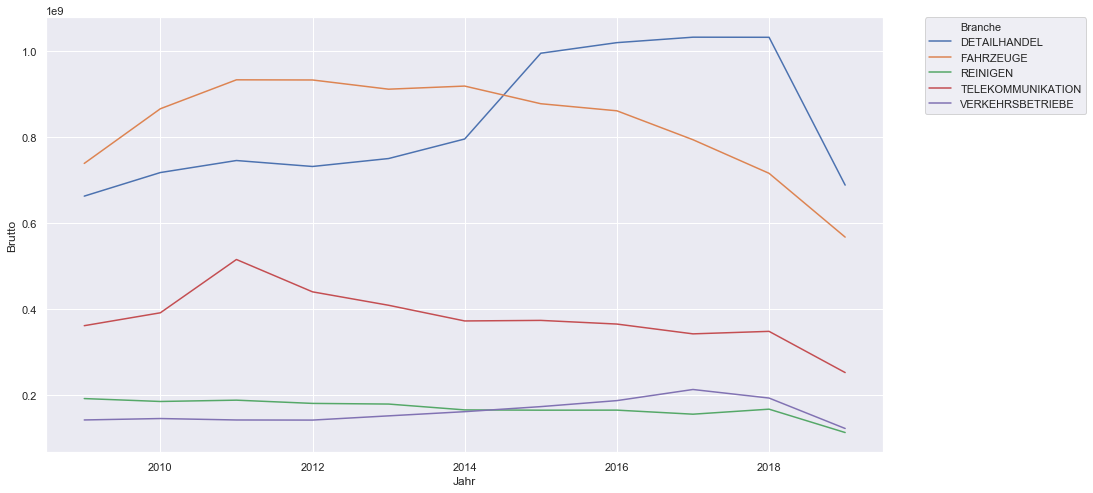

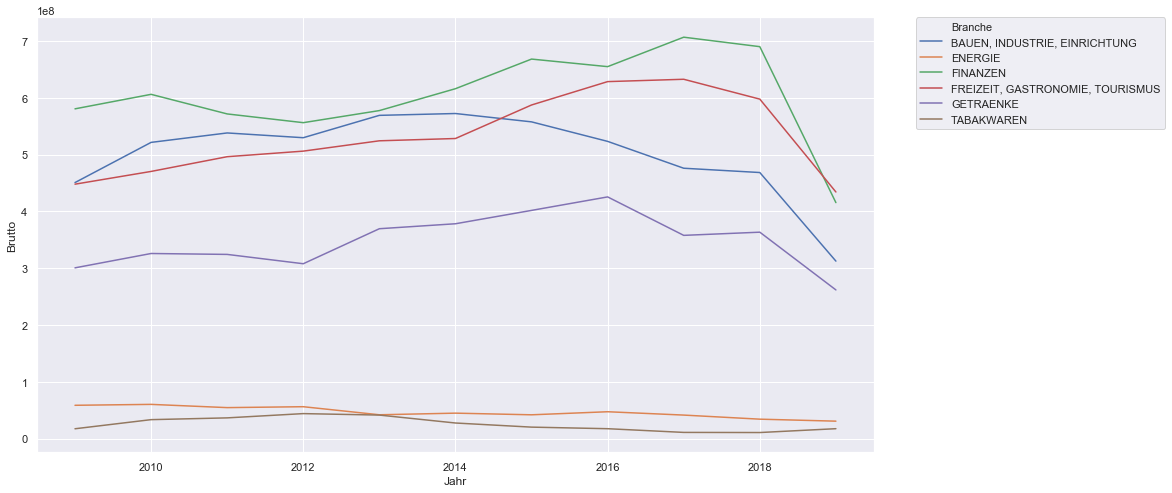

In [70]:
lineplot_branches(select_branches=branchen_liste[0:5])
lineplot_branches(select_branches=branchen_liste[5:10])
lineplot_branches(select_branches=branchen_liste[10:15])
lineplot_branches(select_branches=branchen_liste[15:])


In [40]:
#br_kw = br_kw.astype({'Jahr': 'int64'})

row_without_2019 = (br_kw.loc[:,"Jahr"] < 2019)

br_kw_without_2019 = calc_col_partitioned(
    df=br_kw.loc[row_without_2019,:],
    col="Brutto_Relativ",
    #fun="max",
    fun=lambda s: (s - s.min()) / (s.max() - s.min()),
    on="Brutto",
    part_by="Branche")
 #.loc[:,["Branche", "Jahr", "Brutto", "Brutto_Relativ"]]
 #.sort_values(["Branche", "Jahr"], ascending=[True, True]))

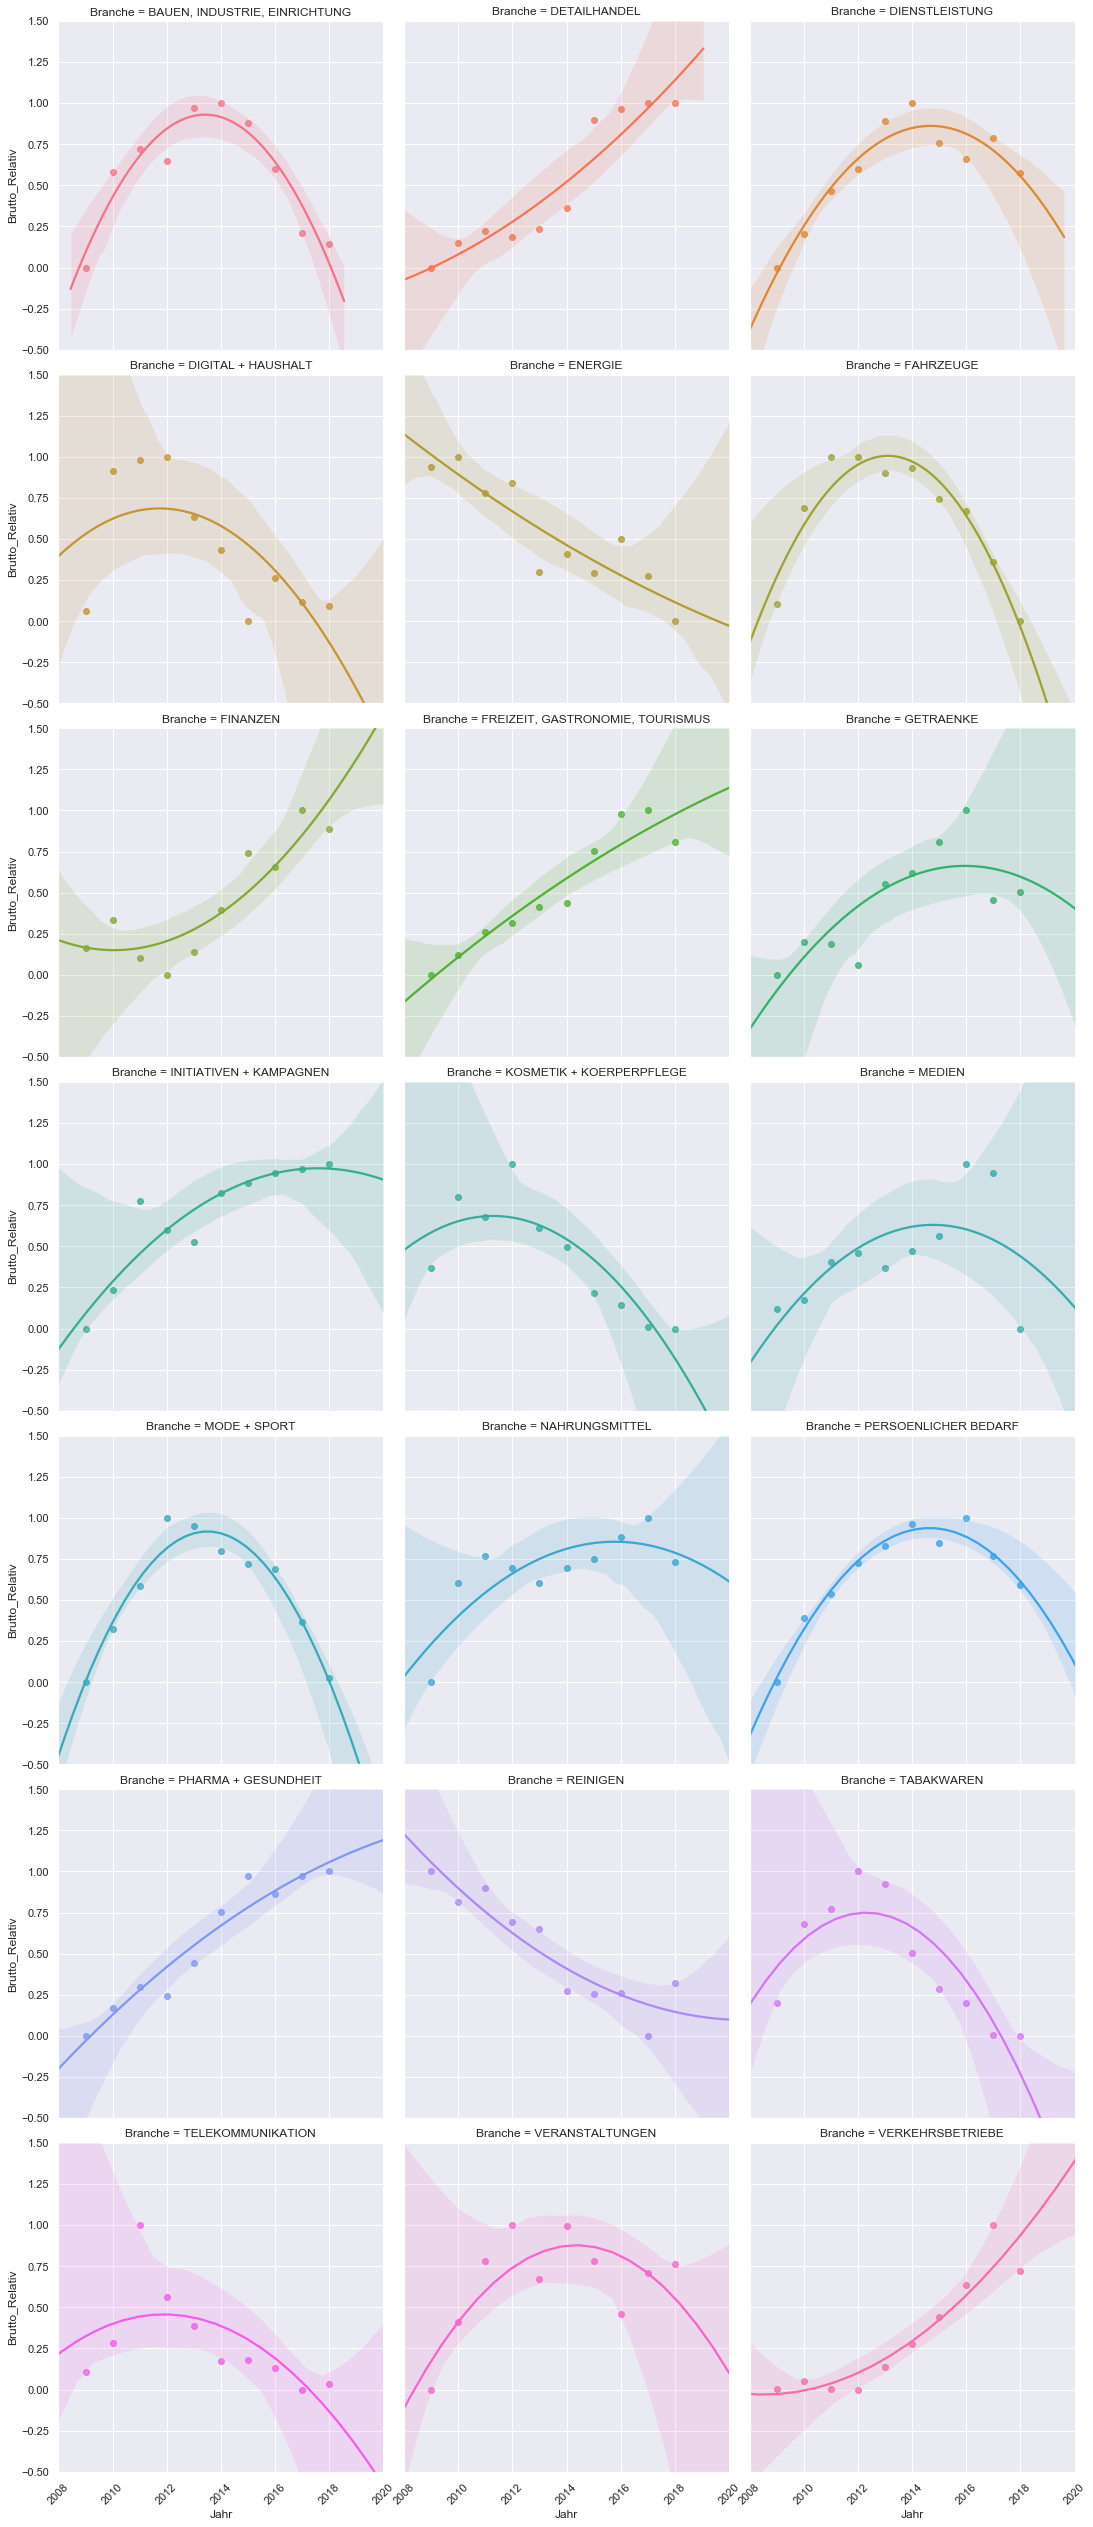

In [61]:
#br_kw
g = sns.lmplot(
    x        = "Jahr",
    y        = "Brutto_Relativ",
    col      = "Branche",
    hue      = "Branche", # kinda useless, but nice to look at!
    data     = br_kw_without_2019,
    col_wrap = 3, # How many plots per row
    height   = 5,
    order    = 2, # polynomial regression of order, best for 1 or 2
    #ci       = 95,
).set(xlim=(2008, 2020),ylim=(-0.5,1.5))

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

## Melting `br_kw`

In [97]:
from pa_lib.util import iso_to_datetime

In [82]:
br_kw.head(10)

,Jahr,Branche,KW_01,KW_02,KW_03,KW_04,KW_05,KW_06,KW_07,KW_08,KW_09,KW_10,KW_11,KW_12,KW_13,KW_14,KW_15,KW_16,KW_17,KW_18,KW_19,KW_20,KW_21,KW_22,KW_23,KW_24,KW_25,KW_26,KW_27,KW_28,KW_29,KW_30,KW_31,KW_32,KW_33,KW_34,KW_35,KW_36,KW_37,KW_38,KW_39,KW_40,KW_41,KW_42,KW_43,KW_44,KW_45,KW_46,KW_47,KW_48,KW_49,KW_50,KW_51,KW_52,KW_53,Brutto,Brutto_Relativ
0,2009,"BAUEN, INDUSTRIE, EINRICHTUNG",1475891,2919457,2920115,3320761,3561250,3471169,3354064,4276107,3900002,4154680,4208414,6213296,6122367,6618858,4397194,4491488,5116467,5778062,5162234,4880535,4358518,4717198,4189679,3021469,4171929,4183769,3119433,1940075,1646845,2273324,1984416,2102742,3061546,3935922,4035648,4881130,4160343,5478326,6376138,6329324,7408536,5914194,6954294,5688355,5948818,4032135,4494710,6011579,4402333,3673181,3423699,2827843,2282409,450744542,0.532156
1,2009,DETAILHANDEL,3809664,6759038,7012067,4266813,7261881,4658060,5077131,4920776,6491423,4792526,5289118,6091374,5798821,6504253,6028183,6392650,6909910,7359485,6401493,4710896,6713022,5728434,7140533,4932778,5065366,5518464,5928008,4730800,5434855,5365445,7463936,5622002,4733339,4377539,5352404,6226435,5685182,5442993,7689321,7482595,8353337,6410230,6514572,7487712,6792942,6248210,6417471,7663644,13043263,8764256,9209719,5787285,5363664,662450636,0.000000
2,2009,DIENSTLEISTUNG,1868443,3192781,3280312,3321827,4425565,2666862,2740178,2825309,4349313,3515669,3262267,3637447,4327615,4261216,2174448,1902074,3059587,3900073,2976750,2843062,2566073,3172513,3956265,2214384,2690336,2132785,2869767,1890526,1522255,1628570,2337891,1662102,2277144,2952682,3954983,5793615,3174977,3392314,3131438,4235911,2407336,2717024,3528841,5926138,3683616,3394443,3119892,3094972,4798310,2887974,2784814,1925110,1220761,327153120,0.020696
3,2009,DIGITAL + HAUSHALT,1956595,2692179,1629850,1307705,3097427,1646054,2369871,1895251,3637077,3213532,3863809,3325529,4193534,3889007,3814764,3486740,3837741,5922905,4382198,4037106,3925978,3959128,3772512,2506045,3276792,3173562,4416721,2642339,2346321,2500380,2634203,2781721,1337518,2983597,2825824,4072282,3694126,3662837,4053842,5382511,3526990,4385593,5807135,7542123,5213853,5147001,6265057,8053454,11279112,8126797,8429549,4342685,1915365,420363654,0.610168
4,2009,ENERGIE,102356,314912,218588,150316,509230,377422,344115,303906,777541,785380,557773,486412,505658,581138,491906,622172,670251,721583,712721,741077,855291,871819,869606,605643,886845,647619,516485,447514,290365,218911,211840,222443,239309,300501,512303,959665,913376,705597,645007,640879,420967,506447,982016,829299,935573,815373,631363,640385,563422,538186,580621,314513,99561,58786402,0.945715
5,2009,FAHRZEUGE,1421435,3493880,7592282,7295029,8829257,7522540,7995409,8802880,8364631,7783930,9327003,11043864,13137871,9832493,7918653,8777689,9882787,8087721,7273893,5906920,7329906,8370087,7100836,6709017,6115314,5560025,6617095,4765235,3075902,3340147,2989652,2599282,3815309,6012973,7743074,10229966,8787335,9761084,11029510,10697249,8713790,10530096,11689935,8974536,6698227,6423481,5132574,5191575,4549579,3086543,2756434,1506666,1037553,738460308,0.468446
6,2009,FINANZEN,1881103,3013268,4152041,4045792,7291410,4672969,3515643,4180068,6602364,5093012,5529150,5794126,5381661,6523655,3819383,3469685,4785805,6888535,5195588,5429815,4358162,4948285,7030955,5581103,5087871,4978750,4017980,1868640,1436503,1360687,2973101,2077616,2863946,3687607,7480339,12724190,7697648,7031611,7237905,12951429,6747621,7174049,9544339,11808566,9974781,8264240,8526534,5562866,7641606,4386750,3362092,1616308,982801,580503908,0.566881
7,2009,"FREIZEIT, GASTRONOMIE, TOURISMUS",2826460,4160197,4769016,3746734,5087255,3681777,3273354,2819805,5293469,4495612,4236381,4564747,4021532,6169529,4457541,3393382,4812468,6310878,4823618,4053045,3811442,4516278,5964040,3751911,4229407,4168053,4793531,2741914,2326114,2265004,3856318,2447717,2527245,3180170,4423441,6364384,5627002,5474361,4900222,5240636,3311923,3012427,4984375,5289204,4341822,4030298,5210375,5610366,5990146,

In [99]:
iso_to_datetime(2019,1,1)

datetime.datetime(2018, 12, 31, 0, 0)

In [146]:
calender_columns = [col for col in br_kw.columns if col.startswith("KW_")]

container_df = (
    pd.melt(
        br_kw,
        id_vars    = ["Branche","Jahr"],
        value_vars = calender_columns,
        var_name   = "KW",
        value_name = "Brutto"
    )
)


#container_df.loc[:,"KW"].map(lambda x : int(x[3:5]))
#container_df.loc[:,"Jahr"]

years_temp = container_df.loc[:,"Jahr"]
kws_temp   = container_df.loc[:,"KW"].map(lambda x : int(x[3:5]))


date_series = years_temp.combine(kws_temp, func=(lambda year, kw: iso_to_datetime(year=year, kw=kw, day=1)))

container_df.loc[:,"Datum"] = date_series

br_kw_datum = container_df.loc[:,["Branche","Datum","Brutto"]].sort_values(["Branche","Datum"])

In [147]:
br_kw_datum.Datum.min()

Timestamp('2008-12-29 00:00:00')

In [148]:
br_kw_datum.head()

,Branche,Datum,Brutto
0,"BAUEN, INDUSTRIE, EINRICHTUNG",2008-12-29,1475891
231,"BAUEN, INDUSTRIE, EINRICHTUNG",2009-01-05,2919457
462,"BAUEN, INDUSTRIE, EINRICHTUNG",2009-01-12,2920115
693,"BAUEN, INDUSTRIE, EINRICHTUNG",2009-01-19,3320761
924,"BAUEN, INDUSTRIE, EINRICHTUNG",2009-01-26,3561250


In [149]:
Datum_Rel = (br_kw_datum.Datum - br_kw_datum.Datum.min()).astype("int64")//86400000000000
br_kw_datum.loc[:,"Datum_Relativ"] = Datum_Rel



br_kw_datum = calc_col_partitioned(
    df=br_kw_datum,
    col="Brutto_Relativ",
    #fun="max",
    fun=lambda s: (s - s.min()) / (s.max() - s.min()),
    on="Brutto",
    part_by="Branche")


In [150]:
br_kw_datum.head()

,Branche,Datum,Brutto,Datum_Relativ,Brutto_Relativ
0,"BAUEN, INDUSTRIE, EINRICHTUNG",2008-12-29,1475891,0,0.152056
231,"BAUEN, INDUSTRIE, EINRICHTUNG",2009-01-05,2919457,7,0.300782
462,"BAUEN, INDUSTRIE, EINRICHTUNG",2009-01-12,2920115,14,0.300850
693,"BAUEN, INDUSTRIE, EINRICHTUNG",2009-01-19,3320761,21,0.342127
924,"BAUEN, INDUSTRIE, EINRICHTUNG",2009-01-26,3561250,28,0.366904


In [152]:
br_kw_datum.Datum_Relativ.max()

4018

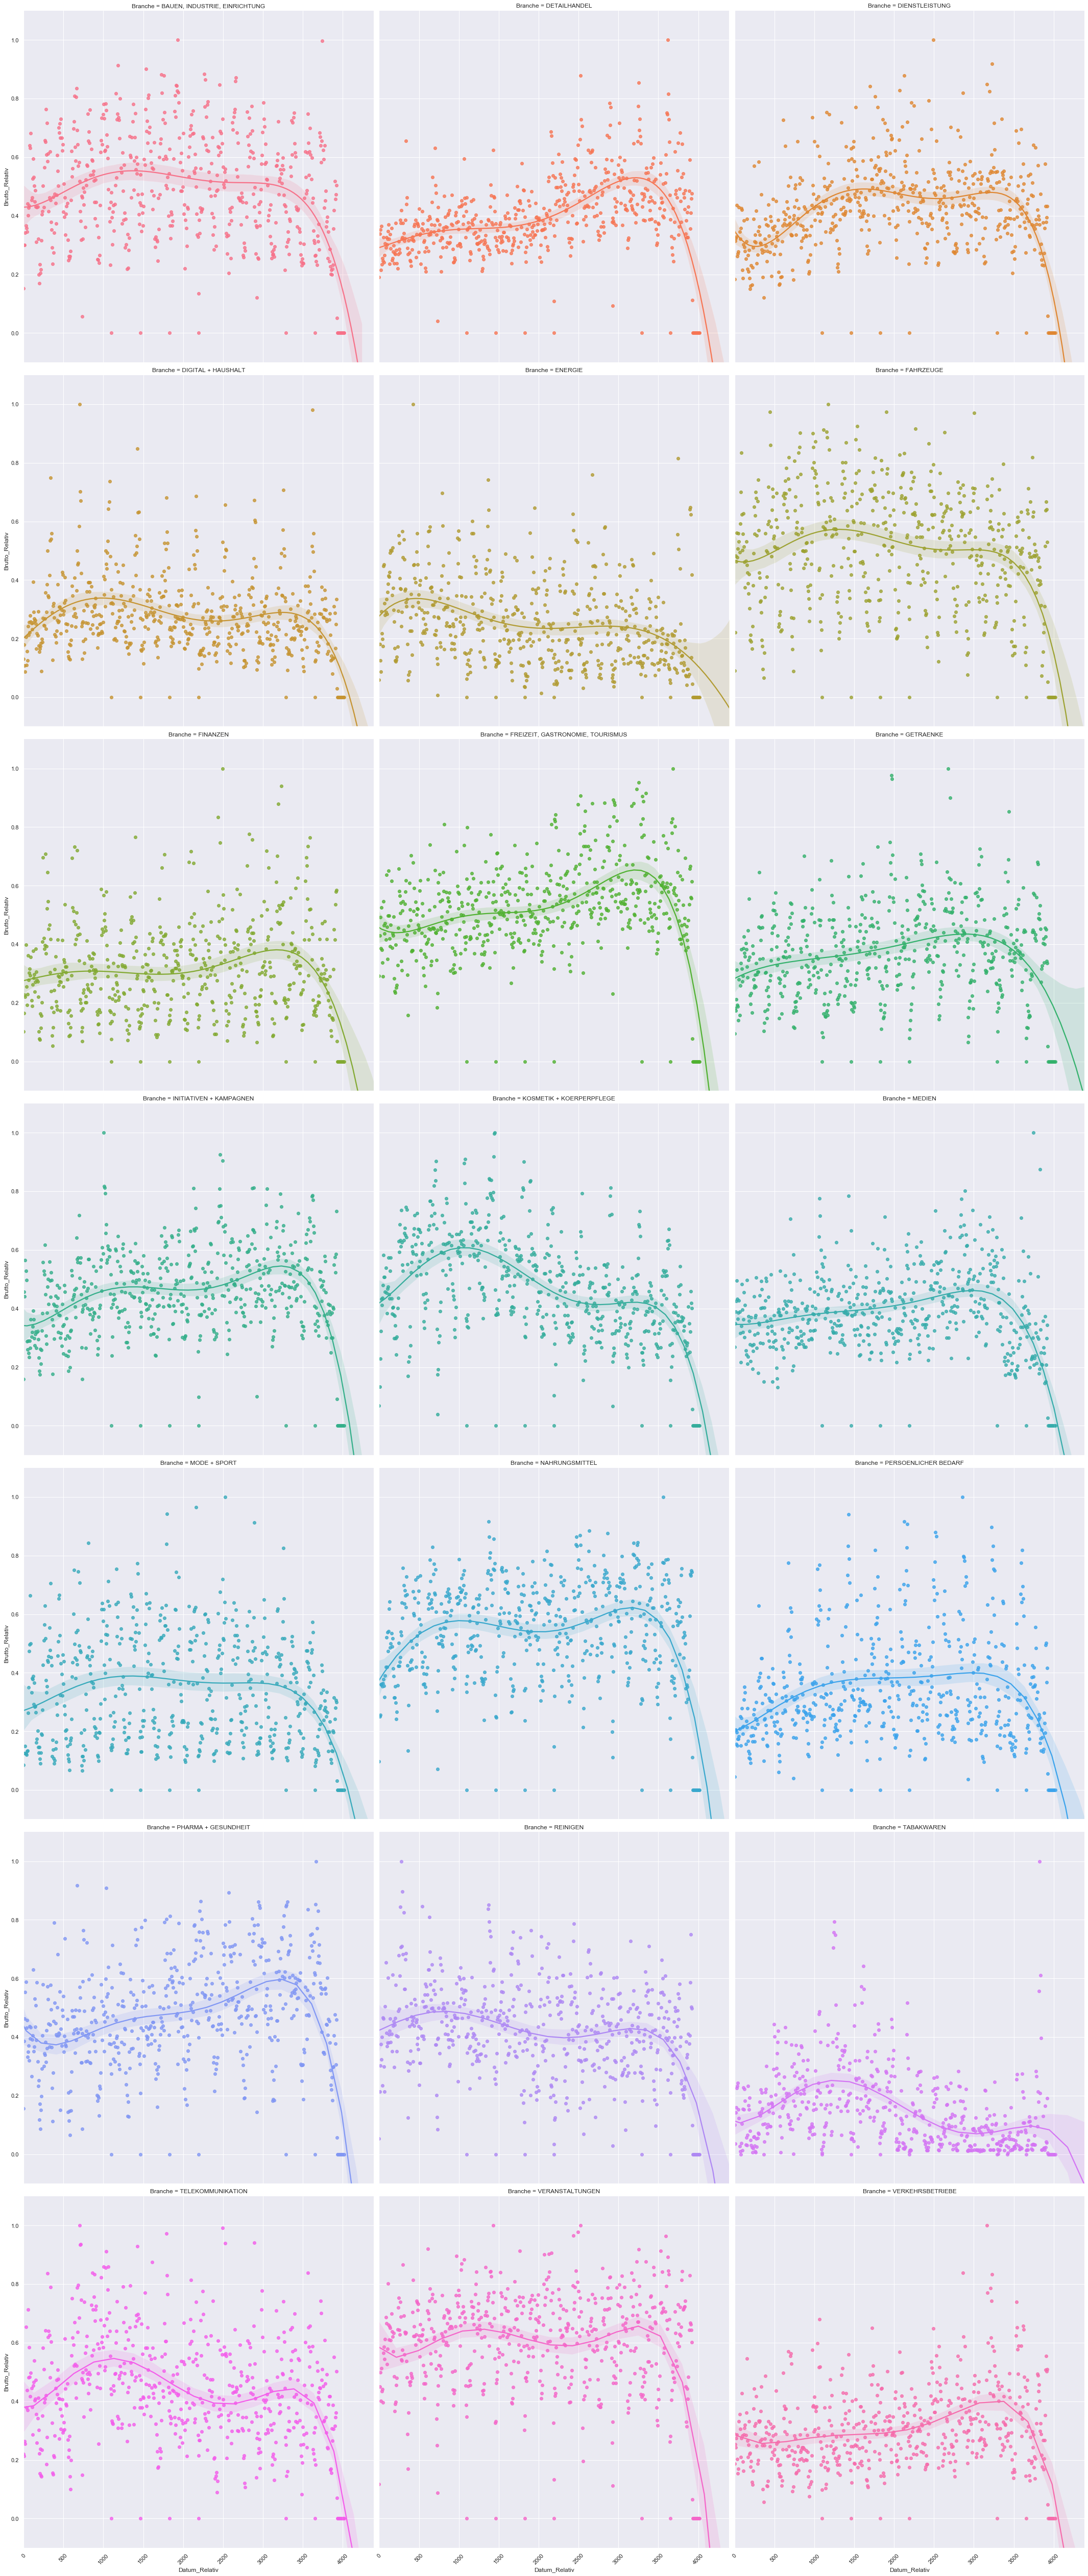

In [156]:
g = sns.lmplot(
    x        = "Datum_Relativ",
    y        = "Brutto_Relativ",
    col      = "Branche",
    hue      = "Branche", # kinda useless, but nice to look at!
    data     = br_kw_datum,
    col_wrap = 3, # How many plots per row
    height   = 10,
    order    = 5, # polynomial regression of order, best for 1 or 2
    #ci       = 95,
).set(xlim=(br_kw_datum.Datum_Relativ.min(), br_kw_datum.Datum_Relativ.max()+368),ylim=(-.1,1.1))

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)


# Scribbles

In [73]:
br_kw.sample(4)

,Jahr,Branche,KW_01,KW_02,KW_03,KW_04,KW_05,KW_06,KW_07,KW_08,KW_09,KW_10,KW_11,KW_12,KW_13,KW_14,KW_15,KW_16,KW_17,KW_18,KW_19,KW_20,KW_21,KW_22,KW_23,KW_24,KW_25,KW_26,KW_27,KW_28,KW_29,KW_30,KW_31,KW_32,KW_33,KW_34,KW_35,KW_36,KW_37,KW_38,KW_39,KW_40,KW_41,KW_42,KW_43,KW_44,KW_45,KW_46,KW_47,KW_48,KW_49,KW_50,KW_51,KW_52,KW_53,Brutto,Brutto_Relativ
208,2018,VERANSTALTUNGEN,3433697,3733200,3504300,4019914,4224769,3864335,3361576,4139210,7257809,5829488,5168603,4433835,5062014,4440521,5724378,5424041,6267766,6299291,4314906,5377655,5964635,7103594,6896005,5980752,5563872,5520315,4380104,3137503,2773906,2627154,3651838,3366322,4033523,6077689,7564425,6114807,5819298,6978806,5871427,5948367,4683378,4821971,5847364,7985208,6575702,5608023,5364433,7395842,6999771,6908525,5626960,2165551,0,542476756,0.912435
133,2015,"FREIZEIT, GASTRONOMIE, TOURISMUS",3060452,8002706,7938284,8157294,7732457,5202092,5866877,4760109,6974077,5853349,5493905,5295456,6072784,5361350,3606434,4457869,5010867,5802896,4600039,5353316,6172236,5459919,6220659,5718330,6286391,6857289,5315415,3891976,3206809,2980198,4422623,3467705,4457331,4531397,5126464,5926441,4605239,5538666,6366084,6456056,4901244,4503232,5156052,8501034,4967509,6205262,6519100,7541277,8791199,6836270,5260491,3920283,2931209,587288006,0.771826
173,2017,FAHRZEUGE,3161268,5121608,8850060,7523906,9960010,8990344,7598960,7953277,11252243,10553769,10982368,15297748,11212689,8607514,6160039,7394809,7619311,10195158,7092752,5350560,5132672,7972541,6682643,7577014,7100558,7212419,6106955,5281847,3345338,3468485,5495042,4072345,4323967,5177761,10650568,11354861,6648785,8224533,9110171,9432769,10048525,9177614,10846129,11755612,9033200,7100487,8490129,7961405,3766305,3892368,4036661,5419685,0,793555574,0.619159
219,2019,INITIATIVEN + KAMPAGNEN,5050430,4713772,5866538,5196910,5583455,4912737,4463050,5490002,7667218,7244676,7622490,6904686,6192415,6968274,7165912,6741265,5473593,8411728,8170182,6618501,4362410,5185904,5564454,4998609,6039860,5678852,5997338,5521722,3624744,4375521,5598960,4372655,5891318,5818981,7993861,8367138,7615561,8515365,10647103,1332685,0,0,0,0,0,0,0,0,0,0,0,0,0,487921750,0.000000


## Prophet

- https://facebook.github.io/prophet/
- https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a

In [16]:
import fbprophet